# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import joblib

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Load Dataset from Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv("/content/drive/MyDrive/dayo/onlinepaymentfraud/PS_20174392719_1491204439457_log.csv")
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Checking data shape

In [4]:
def checkingData(mydata):
  # Checking the shape of the dataset
  mydata.shape
  print(f"There are {mydata.shape[0]} rows and {mydata.shape[1]} columns")
  print("\n")

  # Check if data has null value
  mydata.isnull().sum()

In [5]:
checkingData(data)

There are 6362620 rows and 11 columns




# EDA: Data Overview

In [6]:
print("\nDataset Info:")
print(data.info())

print("\nFirst Five Rows of the Dataset:")
print(data.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None

First Five Rows of the Dataset:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT 

# EDA: Transaction Type Distribution

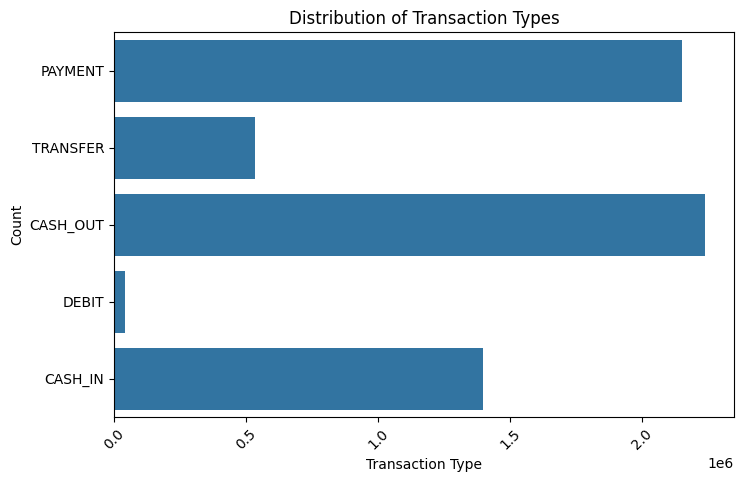

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(data["type"])
plt.title("Distribution of Transaction Types")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# EDA: Correlation Heatmap

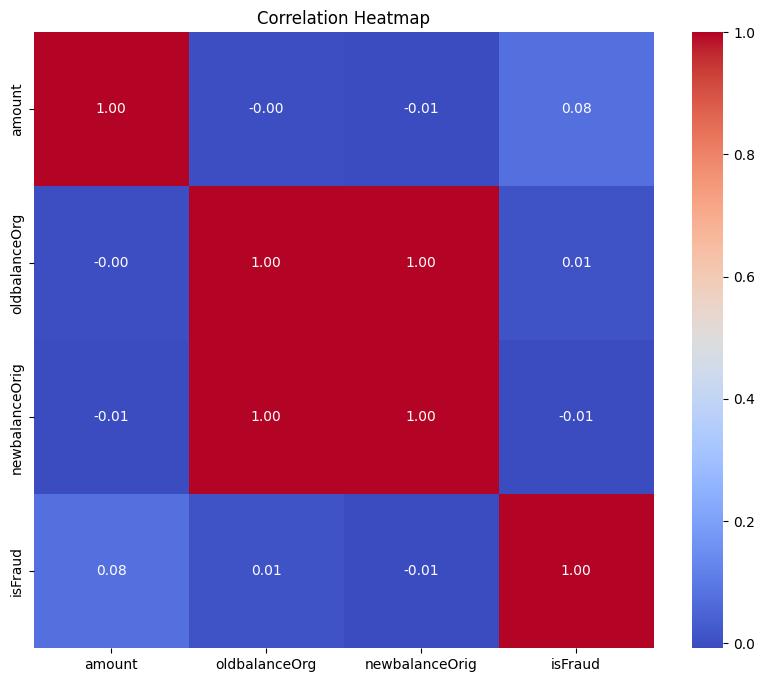

In [8]:
plt.figure(figsize=(10, 8))
correlation_matrix = data[["amount", "oldbalanceOrg", "newbalanceOrig", "isFraud"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Data Preprocessing

In [9]:
data["type"] = data["type"].map({"CASH_OUT": 1, "PAYMENT": 2, "CASH_IN": 3, "TRANSFER": 4, "DEBIT": 5})
data["isFraud"] = data["isFraud"]

# Feature Engineering

In [10]:
data["balance_diff"] = data["oldbalanceOrg"] - data["newbalanceOrig"]
features = ["type", "amount", "oldbalanceOrg", "newbalanceOrig", "balance_diff"]

# Selecting Features and Target

In [11]:
x = data[features]
y = data["isFraud"]

# Splitting the dataset

In [12]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.30, random_state=42, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# Scaling the data

In [13]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# Choose a Model: Random Forest, XGBoost, or LightGBM

In [14]:
# Model 1: Random Forest
rfmodel = RandomForestClassifier(class_weight="balanced", random_state=42)

# Model 2: XGBoost
xgbmodel = XGBClassifier(use_label_encoder=False, eval_metric="logloss", scale_pos_weight=5, random_state=42)

# Model 3: LightGBM
lgbmmodel = LGBMClassifier(class_weight="balanced", random_state=42)

# Train the model

In [15]:
rfmodel.fit(x_train, y_train)
xgbmodel.fit(x_train, y_train)
lgbmmodel.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:16:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 5749, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1026
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', random_state=42)

# Save the trained model

In [16]:
joblib.dump(rfmodel, "random_forest_model.pkl")
print("Model saved as 'random_forest_model.pkl'.")

joblib.dump(xgbmodel, "xgb_model.pkl")
print("\nModel saved as 'xgb_model.pkl'.")

joblib.dump(lgbmmodel, "lgbm_model.pkl")
print("\nModel saved as 'lgbm_model.pkl'.")

Model saved as 'random_forest_model.pkl'.

Model saved as 'xgb_model.pkl'.

Model saved as 'lgbm_model.pkl'.


# Load the saved models

In [17]:
loaded_rfmodel = joblib.load("random_forest_model.pkl")
loaded_xgbmodel = joblib.load("xgb_model.pkl")
loaded_lgbmmodel = joblib.load("lgbm_model.pkl")

# Validation

In [18]:
y_val_pred_rf = loaded_rfmodel.predict(x_val)
y_val_pred_xgb = loaded_xgbmodel.predict(x_val)
y_val_pred_lgbm = loaded_lgbmmodel.predict(x_val)

# Testing

In [19]:
y_test_pred_rf = loaded_rfmodel.predict(x_test)
y_test_pred_xgb = loaded_xgbmodel.predict(x_test)
y_test_pred_lgbm = loaded_lgbmmodel.predict(x_test)

# Evaluation on Validation Dataset

In [20]:
print("\nValidation Results for Random Forest model:")
print("Validation Accuracy for Random Forest:", loaded_rfmodel.score(x_val, y_val))
print("Classification Report (Validation):\n", classification_report(y_val, y_val_pred_rf))

print("\nValidation Results for XGBoost model:")
print("Validation Accuracy for XGBoost:", loaded_xgbmodel.score(x_val, y_val))
print("Classification Report (Validation):\n", classification_report(y_val, y_val_pred_xgb))

print("\nValidation Results for LightGBM model:")
print("Validation Accuracy for LightGBM:", loaded_lgbmmodel.score(x_val, y_val))
print("Classification Report (Validation):\n", classification_report(y_val, y_val_pred_lgbm))


Validation Results for Random Forest model:
Validation Accuracy for Random Forest: 0.9997223366055702
Classification Report (Validation):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    953161
           1       0.91      0.88      0.89      1232

    accuracy                           1.00    954393
   macro avg       0.95      0.94      0.95    954393
weighted avg       1.00      1.00      1.00    954393


Validation Results for XGBoost model:
Validation Accuracy for XGBoost: 0.9993304644941864
Classification Report (Validation):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    953161
           1       0.67      0.94      0.78      1232

    accuracy                           1.00    954393
   macro avg       0.84      0.97      0.89    954393
weighted avg       1.00      1.00      1.00    954393


Validation Results for LightGBM model:
Validation Accuracy for LightGBM: 0.99

# Evaluation on Testing Dataset

In [21]:
print("\nTesting Results for Random Forest model:")
print("Test Accuracy:", loaded_rfmodel.score(x_test, y_test))
print("Classification Report (Testing):\n", classification_report(y_test, y_test_pred_rf))

print("\nTesting Results for XGBoost model:")
print("Test Accuracy:", loaded_xgbmodel.score(x_test, y_test))
print("Classification Report (Testing):\n", classification_report(y_test, y_test_pred_xgb))

print("\nTesting Results for LightGBM model:")
print("Test Accuracy:", loaded_lgbmmodel.score(x_test, y_test))
print("Classification Report (Testing):\n", classification_report(y_test, y_test_pred_lgbm))



Testing Results for Random Forest model:
Test Accuracy: 0.999746435692634
Classification Report (Testing):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    953161
           1       0.91      0.89      0.90      1232

    accuracy                           1.00    954393
   macro avg       0.95      0.95      0.95    954393
weighted avg       1.00      1.00      1.00    954393


Testing Results for XGBoost model:
Test Accuracy: 0.9993357034261567
Classification Report (Testing):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    953161
           1       0.67      0.94      0.78      1232

    accuracy                           1.00    954393
   macro avg       0.84      0.97      0.89    954393
weighted avg       1.00      1.00      1.00    954393


Testing Results for LightGBM model:
Test Accuracy: 0.9964962022982147
Classification Report (Testing):
               precision    r

# Confusion Matrix for Testing Dataset

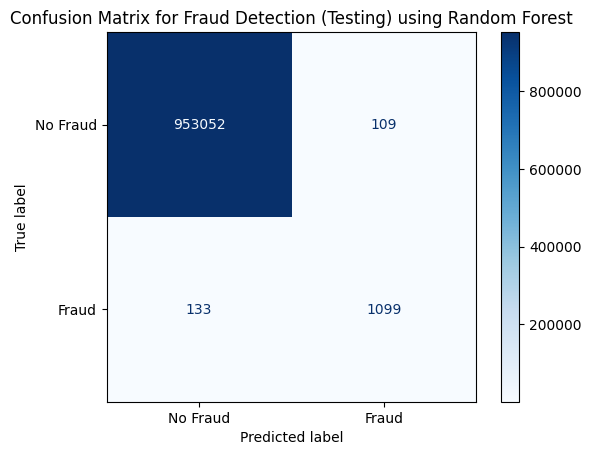

In [22]:
#Confusion Matrix for Random Forest
cmrf = confusion_matrix(y_test, y_test_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cmrf, display_labels=["No Fraud", "Fraud"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Fraud Detection (Testing) using Random Forest")
plt.show()

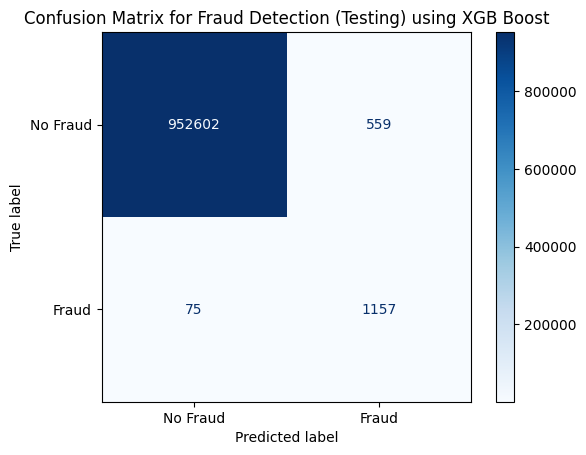

In [23]:
# Confusion Matrix for XGBBoost
cmxgb = confusion_matrix(y_test, y_test_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cmxgb, display_labels=["No Fraud", "Fraud"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Fraud Detection (Testing) using XGB Boost")
plt.show()

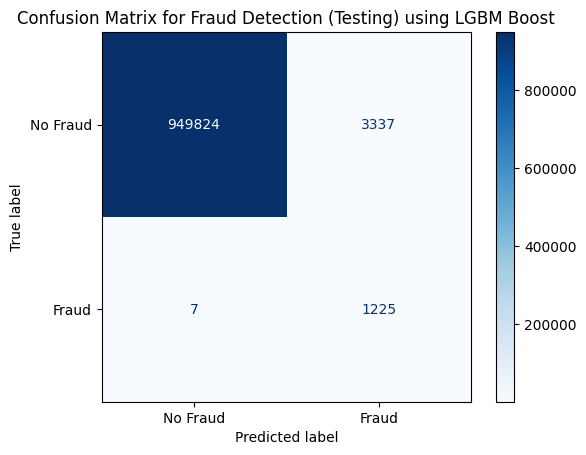

In [24]:
cmlgbm = confusion_matrix(y_test, y_test_pred_lgbm)
disp = ConfusionMatrixDisplay(confusion_matrix=cmlgbm, display_labels=["No Fraud", "Fraud"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Fraud Detection (Testing) using LGBM Boost")
plt.show()